# Data analysis of a single tensile test (CSV)

Lars P. Mikkelsen (lapm@dtu.dk), Composite Materials, DTU Wind Energy, Fall 2020

This jupyter notebook is made in order to investigate individual data set and save the results in a mat-file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import DataAnalysisFuncV1b as daf  # Import functions for data analysis
import copy

StrainRange = (0.05,0.25)

# For Jupyter Notebook plotning
%matplotlib inline  
#%matplotlib notebook 

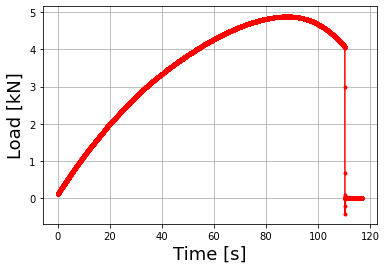

In [2]:
SpecName='EpoxyData-01'
DataFile =SpecName+'.steps.tracking.csv'

time0,load0,strain10,strain20 = np.loadtxt(open(DataFile,'r'),skiprows=1,
     delimiter=';',usecols=(0,8,9,10),dtype=float,unpack=True)

plt.figure()
plt.plot(time0,load0,'r.-')
plt.xlabel('Time [s]',fontsize=18)
plt.ylabel('Load [kN]',fontsize=18)
plt.grid()
plt.show()

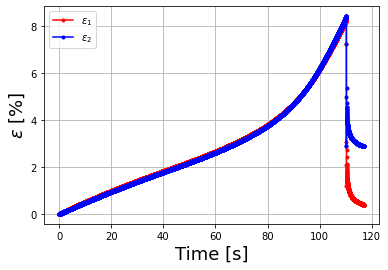

In [3]:
plt.figure()
plt.plot(time0,strain10,'r.-', label=r'$\varepsilon_1$')
plt.plot(time0,strain20,'b.-', label=r'$\varepsilon_2$')
plt.xlabel('Time [s]',fontsize=18)
plt.ylabel(r'$\varepsilon$ [%]',fontsize=18)
plt.legend(loc=2)
plt.grid()
plt.show()

In [4]:
icut=daf.FuncCut(load0,5)  
time=time0[:icut]
strain1=strain10[:icut]
strain2=strain20[:icut]
load=load0[:icut]

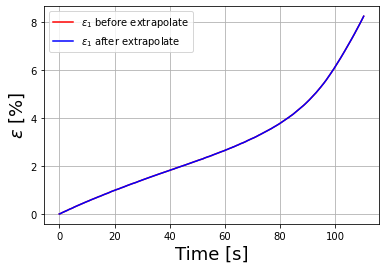

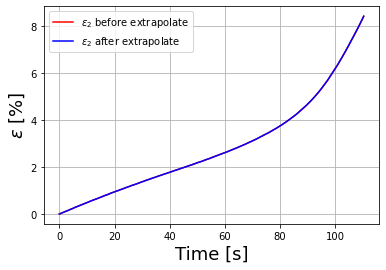

In [5]:
strain1Ini=copy.copy(strain1)
strain2Ini=copy.copy(strain2)

#ia,ib=daf.FuncRange(strain1,(4.5,4.9))
#strain1a=daf.FuncStrainReplace(time,strain1,ia,ib)
strain1a=strain1 # if no extrapolation 

#ia,ib=daf.FuncRange(strain2,(5.5,5.9))
#strain2a=daf.FuncStrainReplace(time,strain2,ia,ib)
strain2a=strain2 # if no extrapolation 

plt.figure()
plt.plot(time,strain1Ini,'r-', label=r'$\varepsilon_1$ before extrapolate')
plt.plot(time,strain1a,'b-', label=r'$\varepsilon_1$ after extrapolate')
plt.xlabel('Time [s]',fontsize=18)
plt.ylabel(r'$\varepsilon$ [%]',fontsize=18)
plt.legend(loc=0)
plt.grid()
plt.show()

plt.figure()
plt.plot(time,strain2Ini,'r-', label=r'$\varepsilon_2$ before extrapolate')
plt.plot(time,strain2a,'b-', label=r'$\varepsilon_2$ after extrapolate')
plt.xlabel('Time [s]',fontsize=18)
plt.ylabel(r'$\varepsilon$ [%]',fontsize=18)
plt.legend(loc=0)
plt.grid()
plt.show()

In [6]:
GeoDataFile='EpoxyDataWT.csv'
SpecLineGeo=daf.ReadLineNumber(GeoDataFile,SpecName,icol0=0,iskip=2,strdel=';')
# Read specific line in GeoDataFile
t1,t2,t3,w1,w2,w3 = np.loadtxt(open(GeoDataFile,'r'),skiprows=SpecLineGeo,delimiter=';'
                    ,usecols=(1,2,3,4,5,6),dtype=float,unpack=True,max_rows=1)
area=(t1+t2+t3)/3.0*(w1+w2+w3)/3.0
A0=area
print('Area=',area,'mm^2 for sample:',SpecName)

Area= 64.49999999999999 mm^2 for sample: EpoxyData-01


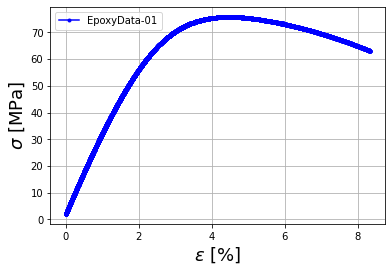

In [7]:
Stress = load*1e3/area               # N/mm^2 = MPa
Strain=(strain1a+strain2a)/2    # Find mean value of strain

plt.figure()
plt.plot(Strain,Stress,'b.-',label=SpecName)
plt.xlabel(r'$\varepsilon$ [%]',fontsize=18)
plt.ylabel(r'$\sigma$ [MPa]',fontsize=18)
plt.legend(loc=0)
plt.grid()
plt.show()

## Balance the strain in a consistent way
When performing the test, the strain measurement will normally be balance when the test is started eventhough there may be a small loads present in the test. It will not alway be possible to put zero load on a test sample as the specimen geometry may be instable even under a small negative load. Here a consistent zero point is defined such that the line used for finding the initial Young modulus is going through $(\sigma,\varepsilon)=(0,0)$

In [8]:
Strain0=copy.copy(Strain)
Stress0=copy.copy(Stress)
Strain=daf.FuncBalanceStrain(Strain,Stress,StrainRange)

## Calculate the true stress versus logarithmic strain
After the strain value has been balanced, the true stress and the logarithmic strain can be calcualted from the norminal stress and the engineering strain  using the following two relation
$$ \varepsilon_{ln}=\ln(1+\varepsilon_e) $$
$$ \sigma_{t}=\sigma_n (1+\varepsilon_e) $$
In this calulation, it is assumed that there are volume constant during the deformation. This will normally not be the case for the elastic deformation but correct for many type of plastic deformation. The plastic deformation, will normally be dominating, therefore this will normally be a good approximation. It can be shown that the deformation in a tensile test will localize e.g. developing a so-called necking zone or shear band at the load maximum. Therefore, it is only meaningfull to consider a tensile curve up the the load maximum. After the load-maximum, the stress versus strain curve will be specimen dependent and dependent on whether the localization are happening inside or outside the strain measurement zone. 

Please note that the function used for true stress, log-strain calculation are assuming that the strain are given in the unit [%]. 

In [9]:
Strain1=copy.copy(Strain)
Stress1=copy.copy(Stress)

# Only save the curve upto the max loading point
imax=np.argmax(load)
Strain=Strain[:imax+1]   # +1 in order to include max point in array
Stress=Stress[:imax+1]
Time=time[:imax+1]

(Strain,Stress)=daf.TrueStress(Strain,Stress)

## Calculating the Young modulus, strain rate and maximum stress
The final point in the data analysis of the tensile test measurement is to calculate the Young modulus defined as the slope of the curve in the range defined by a strain range, a corresponding strain rate found in the same strain range and the maximum stress value calculated both as the nominal and true stress value.

In [10]:
(ia,ib) = daf.FuncRange(Strain,StrainRange)

pEmod = np.polyfit(Strain[ia:ib] , Stress[ia:ib] , 1)
Emod=pEmod[0]/10   # Emod in GPa
EmodStr = r'E=%4.3f GPa' % (Emod)

pEpsRate = np.polyfit(Time[ia:ib] , Strain[ia:ib], 1)
EpsRate=pEpsRate[0]   # EpsRate in [%/s]
EpsRateStr = r'$\dot{\varepsilon}$=%4.3f [%%/s]' % (EpsRate)

# True stress at max load 
iMax=np.abs(load).argmax()
MaxStress=Stress[iMax]
MaxStrain=Strain[iMax]
MaxStressStr =r'$\sigma_t^{max}=%4.1f$ MPa'  % (MaxStress)
# Nominal stress at max load 
MaxStress0=Stress1[iMax]
MaxStrain0=Strain1[iMax]
MaxStress0Str =r'$\sigma_n^{max}=%4.1f$ MPa'  % (MaxStress0)
# Max averaged strain at failure 
iMaxEnd=np.abs(Strain1).argmax()
MaxStress0End=Stress0[iMaxEnd]
MaxStrain0End=Strain0[iMaxEnd]
MaxStrain0EndStr =r'$\varepsilon_e^{max}=%4.1f$ %%'  % (MaxStrain0End)

## Plot of balancing the strain measure

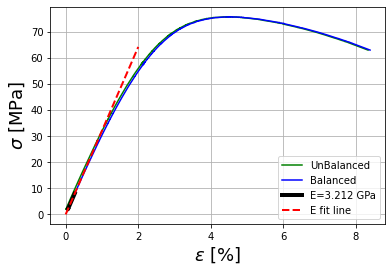

In [11]:
plt.figure()
StrainFit=np.arange(0,MaxStrain/2.0)
plt.plot(Strain0,Stress0,'g-',label='UnBalanced')
plt.plot(Strain1,Stress1,'b-',label='Balanced')
plt.plot(Strain[ia:ib],np.polyval(pEmod,Strain[ia:ib]),'-k',linewidth=4,label=EmodStr)
plt.plot(StrainFit,np.polyval(pEmod,StrainFit),'--r',linewidth=2,label='E fit line')
plt.xlabel(r'$\varepsilon$ [%]',fontsize=18)
plt.ylabel(r'$\sigma$ [MPa]',fontsize=18)
plt.legend(loc=4)
plt.grid()
plt.show()

## Plot of a zoom of the balancing the strain measure

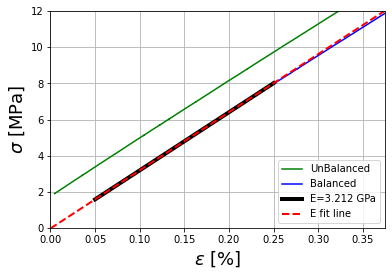

In [12]:
plt.figure()
StrainFit=np.arange(0,MaxStrain/2.0)
plt.plot(Strain0,Stress0,'g-',label='UnBalanced')
plt.plot(Strain1,Stress1,'b-',label='Balanced')
plt.plot(StrainRange,np.polyval(pEmod,StrainRange),'-k',linewidth=4,label=EmodStr)
plt.plot(StrainFit,np.polyval(pEmod,StrainFit),'--r',linewidth=2,label='E fit line')
plt.xlabel(r'$\varepsilon$ [%]',fontsize=18)
plt.ylabel(r'$\sigma$ [MPa]',fontsize=18)
plt.xlim([0,1.5*Strain[ib]])
plt.ylim([0,1.5*Stress[ib]])
plt.legend(loc=4)
plt.grid()
plt.show()

## Plot of the strain versus time curve

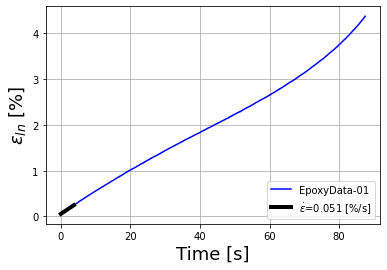

In [13]:
plt.figure()
plt.plot(Time,Strain,'b-',label=SpecName)
plt.plot(Time[ia:ib],np.polyval(pEpsRate,Time[ia:ib]),'-k',linewidth=4,label=EpsRateStr)
plt.ylabel(r'$\varepsilon_{ln}$ [%]',fontsize=18)
plt.xlabel(r'Time [s]',fontsize=18)
plt.legend(loc=4)
plt.grid()
plt.show()

## Plot of the stress versus strain curve

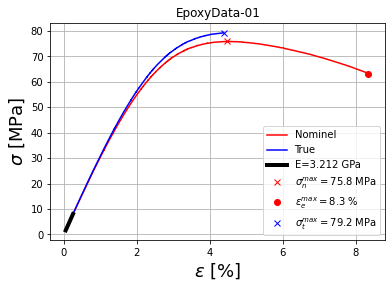

In [14]:

plt.figure()
plt.title(SpecName)
plt.plot(Strain1,Stress1,'r-',label='Nominel')
plt.plot(Strain,Stress,'b-',label='True')
plt.plot(StrainRange,np.polyval(pEmod,StrainRange),'-k',linewidth=4,label=EmodStr)
plt.plot(MaxStrain0,MaxStress0,'rx',label=MaxStress0Str)
plt.plot(MaxStrain0End,MaxStress0End,'ro',label=MaxStrain0EndStr)
plt.plot(MaxStrain,MaxStress,'bx',label=MaxStressStr)
plt.xlabel(r'$\varepsilon$ [%]',fontsize=18)
plt.ylabel(r'$\sigma$ [MPa]',fontsize=18)
plt.legend(loc=4)
plt.grid()
plt.savefig(SpecName+'.png', bbox_inches='tight')
plt.show()

## Save data for summery plot

In [15]:
import scipy.io
scipy.io.savemat(SpecName+'.mat',{'Time': Time, 'Strain': Strain, 'Stress': Stress,
                                  'Strain0':Strain1, 'Stress0':Stress1,
                                  'pEmod': pEmod,'pEpsRate': pEpsRate,
                                  'area': area, 'EpsRate': EpsRate,'Emod': Emod,
                                  'MaxStrain': MaxStrain,'MaxStress': MaxStress,
                                  'MaxStrain0': MaxStrain0,'MaxStress0': MaxStress0,
                                  'MaxStrain0End': MaxStrain0End,'MaxStress0End':MaxStress0End})